In [1]:
import tensorflow as tf
from yolo_preprocessing import PreprocessingClass
import numpy as np

PATH_DATASET = "/home/ubuntu/Datasets/Images/PASCALVOC2007/"
PATH_DATASET_TRAIN = PATH_DATASET + "voctrainval_06-nov-2007/VOCdevkit/VOC2007/"
PATH_DATASET_TEST = PATH_DATASET + "voctest_06-nov-2007/VOCdevkit/VOC2007/" 

img_sizes = (224, 224)
# If full_imgs=True, load all images regardless of n_imgs
X_train, y_bboxes_train, y_labels_train = PreprocessingClass.load_dataset(PATH_DATASET_TRAIN, scale_bbox=True, image_target_size=img_sizes, n_imgs=10, full_imgs=True)

Loaded file: 5011/5011


### Preprocessing

In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_preprocess = preprocess_input(X_train)

In [3]:
from yolo_preprocessing import PreprocessingClass
y_train_labels_onehot, uniq_classes, counts = PreprocessingClass.to_one_hot(y_labels_train)

In [4]:
y_bboxes_train_normalized = PreprocessingClass.xywh_pixels_to_normalized_centers_per_image(y_bboxes_train, img_sizes)

for i in range(len(y_bboxes_train_normalized)):
    y_bboxes_train_normalized[i] = np.array(y_bboxes_train_normalized[i]).reshape(-1, 4)

PreprocessingClass.bbox_labels_info(y_bboxes_train_normalized)

xmin_min_val: 0.013, xmin_avg: 0.502, xmin_max_val: 0.996
ymin_min_val: 0.01657, ymin_avg: 0.5381, ymin_max_val: 0.991
w_min_val: 0.008, w_avg: 0.2813, w_max_val: 0.998
h_min_val: 0.007839, h_avg: 0.362, h_max_val: 0.998
Number of bboxes: 17216


In [5]:
S, B, C = 7, 2, 23
y_train_encoded = PreprocessingClass.encode_batch(y_bboxes_train_normalized, y_train_labels_onehot, S=S, B=B, C=C)
PreprocessingClass.check_map_values(y_train_encoded)

x center: min val = 0.000, mean val = 0.500, max val = 0.999
y center: min val = 0.000, mean val = 0.503, max val = 0.998
w center: min val = 0.010, mean val = 0.305, max val = 0.998
h center: min val = 0.011, mean val = 0.387, max val = 1.000


I0000 00:00:1762238868.678978   51849 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13379 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
del y_bboxes_train
del y_labels_train
del y_train_labels_onehot
del y_bboxes_train_normalized

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_preprocess, y_train_encoded,  test_size=0.2)

In [8]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

del X_train
del X_train_preprocess
del y_train_encoded
del y_train

2025-11-04 07:47:56.109328: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2413264896 exceeds 10% of free system memory.
2025-11-04 07:47:58.874841: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2413264896 exceeds 10% of free system memory.


In [9]:
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)

del X_valid
del y_valid

2025-11-04 07:48:00.718152: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 603918336 exceeds 10% of free system memory.
2025-11-04 07:48:01.188652: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 603918336 exceeds 10% of free system memory.


### Model

In [10]:
def create_yolo_v1_model(img_size=(224, 224, 3), S=7, B=2, C=23):

    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=img_size
    )

    # Zamrożenie wag backbone
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Dropout(0.5)(x)


    output_dim = S * S * (B * 5 + C)
    x = tf.keras.layers.Dense(output_dim)(x)
    x = tf.keras.layers.Reshape((S, S, B * 5 + C))(x)

    xy = tf.keras.layers.Lambda(lambda t: tf.sigmoid(t[..., 0:2*B]))(x)
    wh = tf.keras.layers.Lambda(lambda t: t[..., 2*B:4*B])(x)
    conf = tf.keras.layers.Lambda(lambda t: tf.sigmoid(t[..., 4*B:5*B]))(x)
    classes = tf.keras.layers.Lambda(lambda t: tf.nn.softmax(t[..., 5*B:], axis=-1))(x)

    output = tf.keras.layers.Concatenate(axis=-1)([xy, wh, conf, classes])

    model = tf.keras.Model(inputs=base_model.input, outputs=output, name="YOLOv1")

    return model

model = create_yolo_v1_model(img_size=(img_sizes[0], img_sizes[1], 3), S=7, B=2, C=23)

/home/ubuntu/miniconda3/envs/new_tensorflow/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### training

In [11]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    """https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"""
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6)

In [12]:
from yolo_loss import MyYoloLoss

loss_fn = MyYoloLoss(S=S, B=B, C=C, lambda_coord=5.0, lambda_noobj=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss=loss_fn, optimizer=optimizer, run_eagerly=False)

In [13]:
epochs = 20
num_iterations = epochs * len(train_dataset)

OneCycleScheduler_callback = OneCycleScheduler(iterations=num_iterations, max_lr=1e-4)
checkPointCallback = tf.keras.callbacks.ModelCheckpoint(
    './weights/weights.keras',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=[ReduceLROnPlateau, OneCycleScheduler_callback, checkPointCallback])

Epoch 1/20


2025-11-04 07:48:03.977915: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2413264896 exceeds 10% of free system memory.
I0000 00:00:1762238889.327083   52000 service.cc:152] XLA service 0x7921c8002b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762238889.327155   52000 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-11-04 07:48:09.537000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762238890.214861   52000 cuda_dnn.cc:529] Loaded cuDNN version 90101


  3/251 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 56.7705  

I0000 00:00:1762238897.717683   52000 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 175ms/step - loss: 45.5934 - val_loss: 18.9353 - learning_rate: 1.9965e-05
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - loss: 34.3094 - val_loss: 15.3721 - learning_rate: 2.9969e-05
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 217ms/step - loss: 25.5656 - val_loss: 10.7505 - learning_rate: 3.9973e-05
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - loss: 21.1676 - val_loss: 9.3933 - learning_rate: 4.9978e-05
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 182ms/step - loss: 19.0418 - val_loss: 8.9497 - learning_rate: 5.9982e-05
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - loss: 17.4763 - val_loss: 8.7625 - learning_rate: 6.9987e-05
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - loss: 15.8807 - val_loss: 8.7466 - learning_rate: 7.9991e-05
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - loss: 14.5348 - val_loss: 8.5967 - learning_rate: 8.9996e-05
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 181ms/step - loss: 1

## Inference

In [14]:
X_test, y_bboxes_test, y_labels_test = PreprocessingClass.load_dataset(PATH_DATASET_TEST, scale_bbox=True, image_target_size=img_sizes, n_imgs=10, full_imgs=False)

X_test_preprocess = preprocess_input(X_test)
y_test_labels_onehot, uniq_classes, counts = PreprocessingClass.to_one_hot(y_labels_test)

y_bboxes_test_normalized = PreprocessingClass.xywh_pixels_to_normalized_centers_per_image(y_bboxes_test, img_sizes)

for i in range(len(y_bboxes_test_normalized)):
    y_bboxes_test_normalized[i] = np.array(y_bboxes_test_normalized[i]).reshape(-1, 4)

y_test_encoded = PreprocessingClass.encode_batch(y_bboxes_test_normalized, y_test_labels_onehot, S=S, B=B, C=C)

Loaded file: 10/10


In [19]:
y_pred = model(X_test[:10], training=False).numpy()

y_pred_decoded = PreprocessingClass.decode_batch(y_pred, S=S, B=B, C=C, img_sizes=img_sizes, conf_thresh=0.3)
print("Detections per image:", [len(r) for r in y_pred_decoded][:10])

Detections per image: [0, 0, 0, 1, 0, 0, 4, 1, 0, 0]


In [20]:
y_test_decoded = PreprocessingClass.decode_batch(y_test_encoded, S=S, B=B, C=C, img_sizes=img_sizes)

#### **NMS**

8.527909278869629 190.08535766601562 23.02084732055664 23.967193603515625


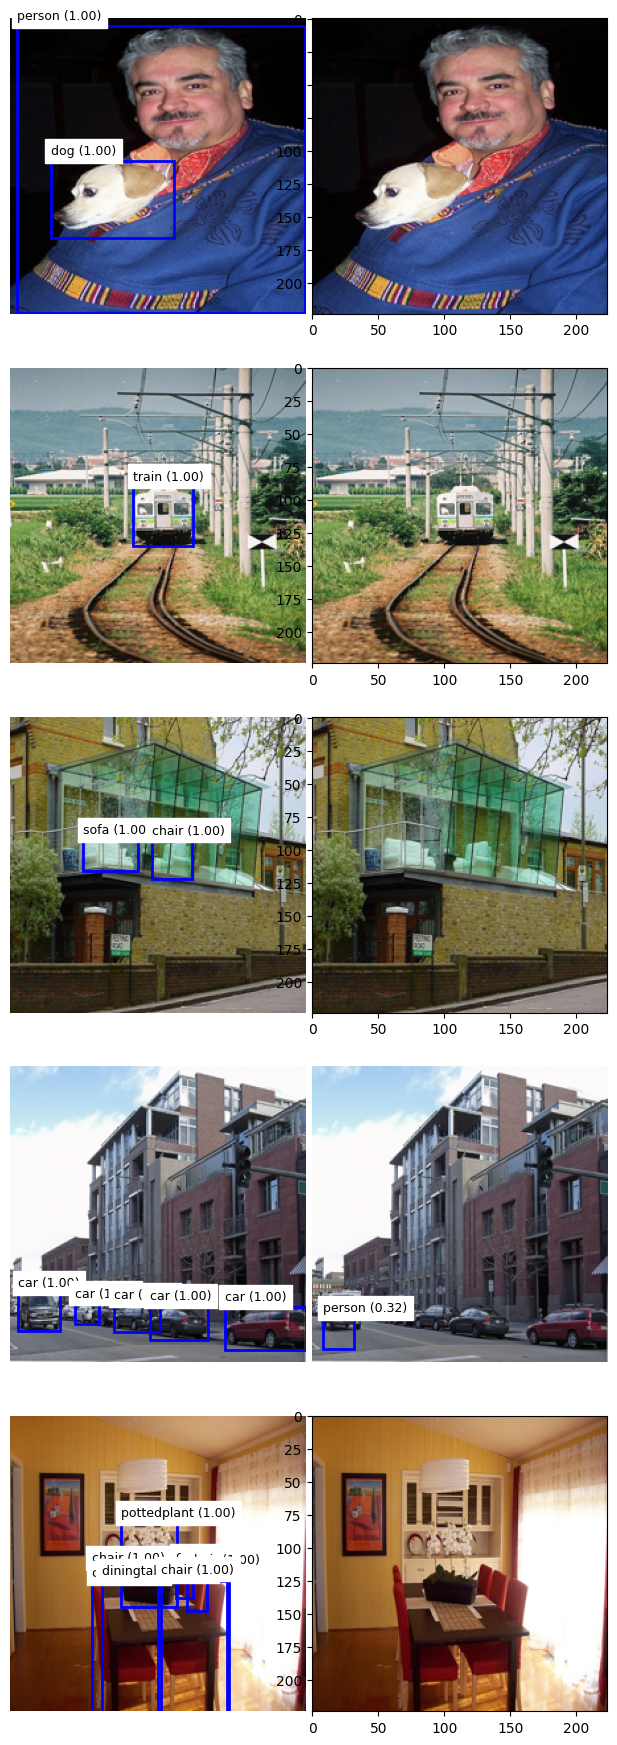

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_img_and_bbox(X, y_bboxes, y_pred_bboxes=False, n_images=1, figsize=(10, 10)):

    fig, ax = plt.subplots(n_images, 2, figsize=(figsize[0], figsize[1]  * n_images))

    if n_images == 1:
        ax = np.array([ax])

    for i in range(n_images):
        ax[i, 0].imshow(X[i])
        ax[i, 1].imshow(X[i])

        # True boxes and labels
        for j in range(len(y_bboxes[i])):

            # Boxes
            bbox_1 = np.array(y_bboxes[i][j])
            x, y, w, h = bbox_1[0], bbox_1[1], bbox_1[2], bbox_1[3]
            rect =  patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none', label='true')    
            ax[i, 0].add_patch(rect)

            # Labels and confs
            conf, label = bbox_1[4], bbox_1[5]
            label_text = uniq_classes[int(label)]
            ax[i, 0].text(x, y -5, f"{label_text} ({conf:.2f})", color='black', fontsize=9, backgroundcolor='white')
            ax[i, 0].axis('off')

        # Pred boxes
        if isinstance(y_pred_bboxes, list):
            for j in range(len(y_pred_bboxes[i])):
                # Boxes
                bbox_2 = np.array(y_pred_bboxes[i][j])
                x, y, w, h = bbox_2[0], bbox_2[1], bbox_2[2], bbox_2[3]
                print(x, y, w, h)
                rect =  patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none', label='true')    
                ax[i, 1].add_patch(rect)

                # Labels and confs
                conf, label = bbox_2[4], bbox_2[5]
                label_text = uniq_classes[int(label)]
                ax[i, 1].text(x, y -5, f"{label_text} ({conf:.2f})", color='black', fontsize=9, backgroundcolor='white')
                ax[i, 1].axis('off')


    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.02, hspace=0.02, top=0.59, bottom=0.01)
    plt.show()

plot_img_and_bbox(X_test, y_test_decoded, y_pred_decoded, n_images=5, figsize=(6, 6))